In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import fiona
import pandas as pd
from math import radians
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances, pairwise_distances
import os
from shapely.ops import unary_union

## Introduction


In [2]:
# helper function to generate a nxn square grid
# returns a GeoDataFrame
def make_grid(n=3):
    xmin, ymin, xmax, ymax = 0, 0, 10*n, 10*n
    
    length = 10
    wide = 10
    
    cols = list(np.arange(xmin, xmax + wide, wide))
    rows = list(np.arange(ymin, ymax + length, length))
    
    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))
    
    grid = gpd.GeoDataFrame({'geometry':polygons})
    return grid

In [3]:
grid = make_grid()
grid['Data'] = list(range(len(grid.index)))

In [4]:
grid[['Data']].to_numpy()

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8]])

<Axes: >

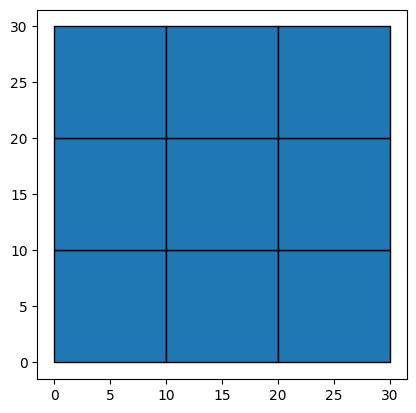

In [5]:
grid.plot(edgecolor='black')

## Evenness
Evenness is a fairly simple measure--if population proportions (ie the ratio of minority members to majority members) is the same across all sub geographies, the area will have perfect evenness.

As a side note, the populations themselves don't have to be even (eg 50% to 50%). They just have to have the same ratio for every sub unit

### Gini

The Gini Coefficient is a popular way to measure evenness. It's an index between 0 and 1, with 0 representing perfect evenness and 1 representing perfect unevenness. The formula explains the idea best:

The formula is $$ \frac{\sum_{i=1}^n \sum_{j=1}^n [t_j t_j  |(p_i - p_j)| ]}{2T^2 P (1-P)} $$

The variables used are
* $p_i$ the proportion of area $i$ that is minority
* $t_i$ the total population of area $i$
* $P$ the overall minority proportion of the area
* $T$ the total population

The denominator is just a scale factor. The main "meat" is in the $|p_i-p_j|$. In words, it sums the pairwise absolute differences between populations

In [1]:
'''
Returns Gini index
y_i: majority (group A) population; Nx1 numpy array
x_i: minority (group B) population; Nx1 numpy array
'''
def gini(y_i,x_i):
    t_i = y_i+x_i
    p_i = x_i/(t_i+1e-6) # add to denominator in case of divide by 0
    T = t_i.sum()
    P = (t_i*p_i).sum()/T
    mat = (t_i*t_i.T * abs(p_i-p_i.T))/(2*T**2*P*(1-P))
    return mat.sum()

In [7]:
grid['y_i'] = [5]*8 + [1000]
grid['x_i'] = [1]*8 +  [200]
grid['p_i'] = grid['x_i']/(grid.x_i+grid.y_i)

In [8]:
gini(grid[['y_i']].to_numpy(), grid[['x_i']].to_numpy())

7.3594662593703504e-09

Here's a quick illustration of Gini coefficient in 3 scenarios. Some things to note:
* In scenario 1, although the actual populations of subunits differ (15 for 3 subunits, 75 for another 3 subunits, and 150 for the last 3 subunits) Gini coefficient is still 0
* Scenario 2 is a "mixed" scenario while scenario 3 is maximum unevenness: some areas contain 0% minority population while others contain 100%

In [9]:
plt.rcParams['image.cmap'] = 'Blues'

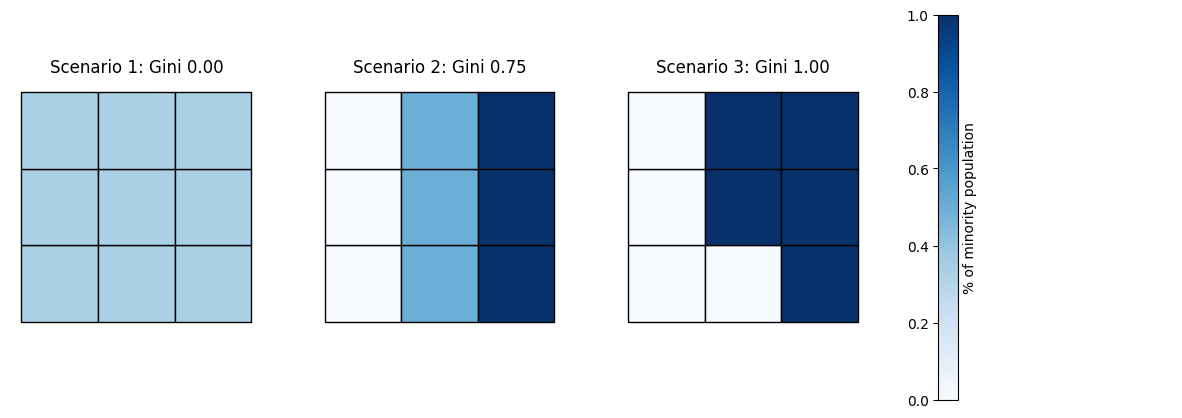

In [10]:
plt.figure(figsize=(15,5))
ax1, ax2, ax3, ax4 = plt.subplot(141), plt.subplot(142), plt.subplot(143), plt.subplot(144)

grid['y_i'] = [10]*3 + [50]*3 + [100]*3
grid['x_i'] = [5]*3 + [25]*3 + [50]*3
grid['p_i'] = grid['x_i']/(grid.x_i+grid.y_i)
grid.plot(column='p_i', edgecolor='black',ax=ax1, vmin=0, vmax=1)
ax1.set_title('Scenario 1: Gini {0:.2f}'.format(gini(grid[['y_i']].to_numpy(), grid[['x_i']].to_numpy())))

grid['y_i'] = [5]*6 + [0]*3
grid['x_i'] = [0]*3 + [5]*6
grid['p_i'] = grid['x_i']/(grid.x_i+grid.y_i)
a = grid.plot(column='p_i', edgecolor='black',ax=ax2, vmin=0, vmax=1)
ax2.set_title('Scenario 2: Gini {0:.2f}'.format(gini(grid[['y_i']].to_numpy(), grid[['x_i']].to_numpy())))

grid['y_i'] = [5]*4 + [0]*5
grid['x_i'] = [0]*4 + [5]*5
grid['p_i'] = grid['x_i']/(grid.x_i+grid.y_i)
grid.plot(column='p_i', edgecolor='black',ax=ax3, vmin=0, vmax=1)
ax3.set_title('Scenario 3: Gini {0:.2f}'.format(gini(grid[['y_i']].to_numpy(), grid[['x_i']].to_numpy())))

for ax in [ax1,ax2,ax3,ax4]:
    ax.axis('off')

# Create a common colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = plt.colorbar(sm, ax=ax4, orientation='vertical', location='left')
cbar.ax.yaxis.set_label_position("right")
l=cbar.ax.set_ylabel('% of minority population')


### Atkinson

Atkinson index is much like the Gini coefficient, but it contains an extra parameter: $b$. For values of $b$ less than .5, minority underrepresentation contributes more to the index; for $b$ greater than .5, minority overrepresentation.

In [3]:
'''
Returns Atkinson index
y_i: majority (group A) population; Nx1 numpy array
x_i: minority (group B) population; Nx1 numpy array
b: parameter of the atkinson index
'''
def atkinson(y_i, x_i, b):
    t_i = y_i+x_i
    p_i = x_i/(t_i+1e-5)
    
    T = t_i.sum()
    P = (t_i*p_i).sum()/T
    mat = (1-p_i)**(1-b)*p_i**b*t_i
    mat = abs(mat.sum())/(P*T+1e-5)
    mat = mat**(1/(1-b))
    return 1 - (P/(1-P))*mat

In [12]:
atkinson(grid[['x_i']].to_numpy(), grid[['y_i']].to_numpy(),.5)

0.9999984000073601

## Exposure
From the Census Bureau's website, exposure measures "the degree to which the average minority group member 'experiences' segregation." Again, the clearest explaination of this concept can come from the formulas. The Isolation Index is defined as 

$$\sum_{i=1}^n [(\frac{x_i}{X})(\frac{x_i}{t_i})]$$

where
* $x_i$ is the minority population of subunit $i$
* $X$ is the total minority population
* $t_i$ is the population of subunit $i$

From the formula, it's much clearer that the $\frac{x_i}{X}$ term is like taking a weighted average of the minority population, and the $\frac{x_i}{t_i}$ term acts as a sort of measure of the "amount of segregation" that the minority population experiences in subunit $i$. So, if the formula evaluates to

$$\frac{1}{2} \cdot 1 + \frac{1}{2} \cdot \frac{1}{2}$$

this means that half the minority population experiences total segregation (only minority members live in the subunit) and the other half of the minority population is in an evenly split subunit. (Any other subunits can have minority population 0, so they will not contribute to the index).

Like the Gini coefficient, values range between 0 and 1. Higher values are worse - they indicate more isolation

### Isolation Index
The examples below populations of 1190 with different distributions. They have roughly the same Isolation index, but different Gini indexes. This is because in both scenarios, minority members experience isolation from the majority members the same on average, even though the actual population distributions are very different

In [4]:
'''
Returns Isolation index
y_i: majority (group A) population; Nx1 numpy array
x_i: minority (group B) population; Nx1 numpy array
'''
def isolation(y_i, x_i):
    t_i = y_i+x_i
    X = x_i.sum()
    iso = (x_i/X)*(x_i/(t_i+1e-6))
    return iso.sum()

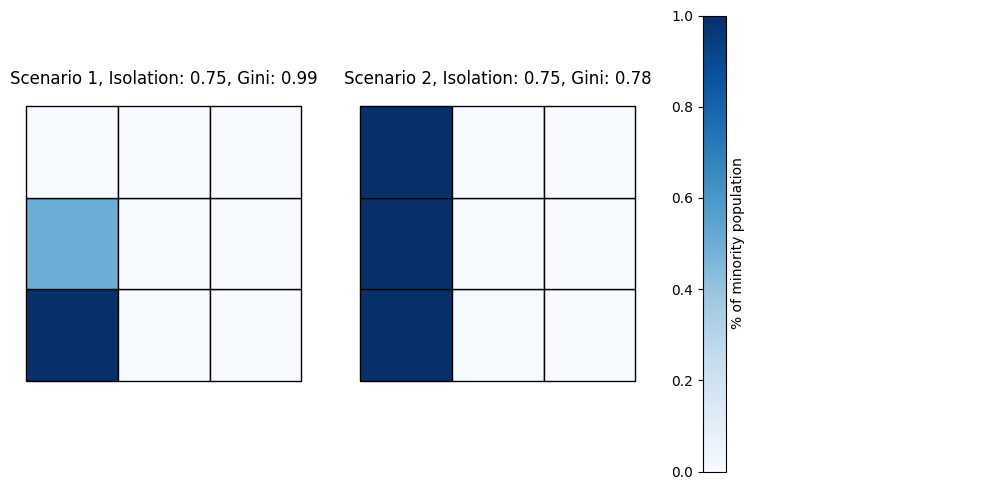

In [14]:
plt.figure(figsize=(10,5))
ax1, ax2, ax3 = plt.subplot(131), plt.subplot(132), plt.subplot(133)

grid['xi'] = [20] + [20] + [0]*7#[29,29,0,0,0,0,0,0,0]
grid['yi'] = [0] + [20] + [161]*6 + [164]
grid['p_i'] = grid['xi']/(grid.xi+grid.yi)
iso, gin = isolation(grid[['yi']].to_numpy(), grid[['xi']].to_numpy()), gini(grid[['yi']].to_numpy(), grid[['xi']].to_numpy())
grid.plot(column='p_i', edgecolor='black',ax=ax1, vmin=0, vmax=1)
ax1.set_title('Scenario 1, Isolation: {0:.2f}, Gini: {1:.2f}'.format(iso, gin))

grid['xi'] = [10]*4 + [0]*5#[29,29,0,0,0,0,0,0,0]
grid['yi'] = [0]*3 + [1000] + [30]*5
grid['p_i'] = grid['xi']/(grid.xi+grid.yi)
iso, gin = isolation(grid[['yi']].to_numpy(), grid[['xi']].to_numpy()), gini(grid[['yi']].to_numpy(), grid[['xi']].to_numpy())
grid.plot(column='p_i', edgecolor='black',ax=ax2, vmin=0, vmax=1)
ax2.set_title('Scenario 2, Isolation: {0:.2f}, Gini: {1:.2f}'.format(iso, gin))
for ax in [ax1,ax2,ax3]:
    ax.axis('off')

# Create a common colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = plt.colorbar(sm, ax=ax3, orientation='vertical', location='left')
cbar.ax.yaxis.set_label_position("right")
l=cbar.ax.set_ylabel('% of minority population')
plt.tight_layout()

## Concentration
The concentration dimension of segregation is different from the previous two in that it incorporates area as well as population. So, it can differentiate between scenarios where minority members are concentrated in a small physical area, versus other scenarios where the ratio of minority members may be similar but the area much larger.

The index shown below is relative concentration which is on a scale from -1 to 1. 0 represents even concentration betweem both groups; -1 means the majority group is much more concentrated than the minority group, and 1 means the minority group is much more concentrated than the majority group.

The formula is a bit more opaque than the previous ones, but decomposing it still makes the meaning of the index clearer. 

$$\frac{\sum_{i=1}^n \frac{x_i a_i}{X}}{\sum_{i=1}^n \frac{y_i a_i}{Y}} - 1$$

Overall, it involves sorting the subunits by area and adding up the total populations of the smallest subunits until they equal the minority population. Likewise, add up the total populations of the largest subunits until they equal the minority population. Then, the index basically shows how many minority group members live in the smallest areas, compared against members of the majority group.

In [5]:
'''
Returns Gini index
y_i: majority (group A) population; Nx1 numpy array
x_i: minority (group B) population; Nx1 numpy array
au_i: land area of geographic subunits; Nx1 numpy array
'''
def concentration(yu_i, xu_i, au_i):
    idx = au_i.argsort(axis=None)
    a_i = au_i[idx]
    y_i = yu_i[idx]
    x_i = xu_i[idx]
    
    t_i = x_i + y_i
    
    X = x_i.sum()
    Y = y_i.sum()
    #print(np.cumsum(t_i[::-1])>=X)
    n1 = (np.cumsum(t_i)>=X).argmax()
    n2 = t_i.shape[0] - (np.cumsum(t_i[::-1])>=X).argmax()-1

    T1 = t_i[:n1+1].sum()
    T2 = t_i[n2:].sum()
    num = (x_i*a_i/(X+1e-5)).sum() / (y_i*a_i/(Y+1e-5)).sum()
    denom1 = (t_i*a_i)[:n1+1].sum()/(T1+1e-5)
    denom2 = (t_i*a_i)[n2:].sum()/(T2+1e-5)
    denom = denom1/denom2
    #print(n1, n2, T1, T2)
    return (num-1)/(denom-1+1e-5)

def abs_concentration(y_i, x_i, a_i):
    t_i = y_i+x_i
    X = x_i.sum()

    n1 = (np.cumsum(t_i)>=X).argmax()
    n2 = t_i.shape[0] - (np.cumsum(t_i[::-1])>=X).argmax()-1

    T1 = t_i[:n1+1].sum()
    T2 = t_i[n2:].sum()

    num = (x_i*a_i/(X+1e-5)).sum() - (t_i*a_i/(T1+1e-5))[:n1+1].sum()
    denom = (t_i*a_i/(T2+1e-5))[n2:].sum() - (t_i*a_i/(T1+1e-5))[:n1+1].sum()
    print(X, n1, n2)
    print(T1, T2)
    print(np.cumsum(a_i)>=X)
    return 1-num/denom

The example below shows three examples for the relative concentration index. In the first scenario, all minority members live in the small area in the center, so the concentration index is very high. In scenario 2, all minority members still live in the same area, but all subunits are equal area, so concentration index is low. 

<Axes: >

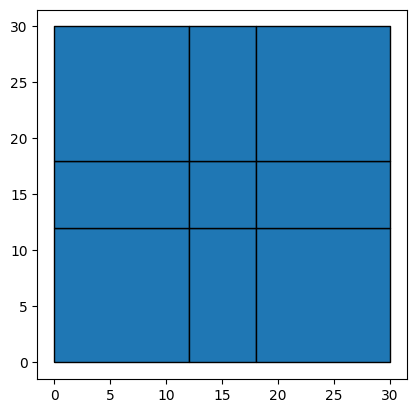

In [16]:
# create grid with different areas
polygons = [Polygon([(0,0), (12,0), (12,12), (0,12)]),
            Polygon([(12,0), (18, 0), (18,12), (12,12)]),
            Polygon([(18,0), (30,0), (30,12), (18,12)]),
            Polygon([(0,12), (12,12), (12,18), (0,18)]),
            Polygon([(12,12), (18,12), (18,18), (12,18)]),
            Polygon([(18,12), (30,12), (30,18), (18,18)]),
            Polygon([(0,18), (12,18), (12,30), (0,30)]),
            Polygon([(12,18), (18,18), (18,30), (12,30)]),
            Polygon([(18,18), (30,18), (30,30), (18,30)])]

grid2 = gpd.GeoDataFrame({'geometry':polygons})
grid2.plot(edgecolor='black')

In [17]:
grid2['xi'] = [0, 5, 0, 5, 20, 5, 0, 5, 0]
grid2['yi'] = [20, 10, 20, 10, 0, 10, 20, 10, 20]
concentration(grid2[['yi']].to_numpy(), grid2[['xi']].to_numpy(), np.array([grid2.area]).T)

0.9166821002577034

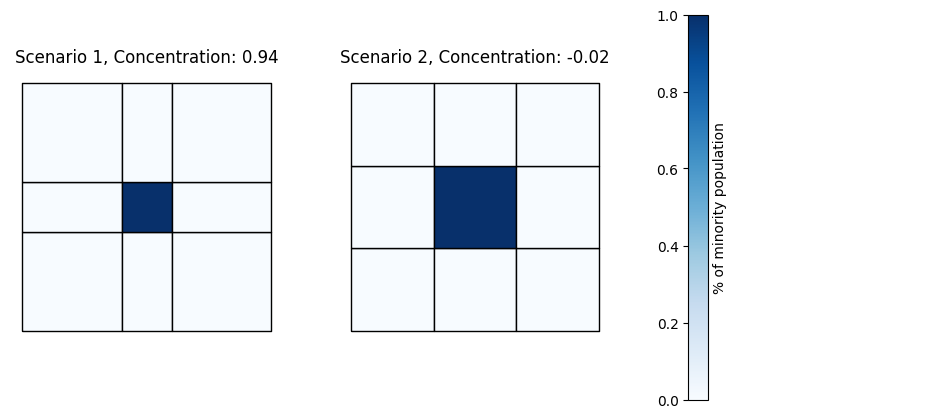

In [18]:
plt.figure(figsize=(12,5))
ax1, ax2, ax3 = plt.subplot(131), plt.subplot(132), plt.subplot(133)

grid2['xi'] = [0, 0, 0, 0, 40, 0, 0, 0, 0]
grid2['yi'] = [20, 10, 20, 5, 0, 10, 20, 10, 20]
grid2['p_i'] = grid2['xi']/(grid2.xi.sum())
grid2.plot(column='p_i', edgecolor='black',ax=ax1, vmin=0, vmax=1)
ax1.set_title('Scenario 1, Concentration: {0:.2f}'.format(concentration(grid2[['yi']].to_numpy(), grid2[['xi']].to_numpy(), np.array([grid2.area]).T)))

grid['xi'] = [0, 0, 0, 0, 40, 0, 0, 0, 0]
grid['yi'] = [20, 10, 20, 5, 0, 10, 20, 10, 20]
grid['p_i'] = grid['xi']/(grid.xi.sum())
grid.plot(column='p_i', edgecolor='black',ax=ax2, vmin=0, vmax=1)
ax2.set_title('Scenario 2, Concentration: {0:.2f}'.format(concentration(grid[['yi']].to_numpy(), grid[['xi']].to_numpy(), np.array([grid.area]).T)))

for ax in [ax1,ax2,ax3]:
    ax.axis('off')

# Create a common colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = plt.colorbar(sm, ax=ax3, orientation='vertical', location='left')
cbar.ax.yaxis.set_label_position("right")
l=cbar.ax.set_ylabel('% of minority population')

## Centralization

The next dimension in []'s paper is Centralization. Unsurprisingly, it measures the tendency of minority members to reside in the center of a city (or other geography being studied).

The index implemented here is relative centralization. Like the other relative measures, it ranges from -1 to 1, where 1 indicates minority members live close to the center while -1 means majority members live close to the center. The formula is

$$\sum_{i=1}^m (X_{i-1}Y_i) - \sum_{i=1}^m (X_i Y_{i-1})$$

where the sunbunits are ordered by increasing distance from the population centroid.

In [19]:
'''
Returns Relative Centralization
y_i: majority (group A) population; Nx1 numpy array
x_i: minority (group B) population; Nx1 numpy array
radians: centroids of each subunit, in radians; Nx1 numpy array
centroid: population centroid of the entire unit; 1x2 numpy array
euclidean: if True, use pairwaise Euclidean distances between [radians] array
    if False, uses haversine distances between [radians] and [centroid]
'''
def relative_centralization(y_i, x_i, radians, centroid, euclidean=False):
    idx = pairwise_distances(radians,centroid).argsort(axis=None) if euclidean else haversine_distances(radians,centroid).argsort(axis=None)

    X_i = np.cumsum(x_i[idx]/(x_i[idx]+1e-6).sum())
    Y_i = np.cumsum(y_i[idx] / (y_i[idx]+1e-6).sum())
    #print(np.roll(X_i, 1))
    return ((np.roll(X_i, 1)*Y_i)[1:]).sum() - ((X_i*np.roll(Y_i,1))[1:]).sum()
    
    

The examples below show differences in the Relative Centralization indexes. In the first two, minority members are in the very central subunit. The second scenario shows centralization for a more evenly spread population.

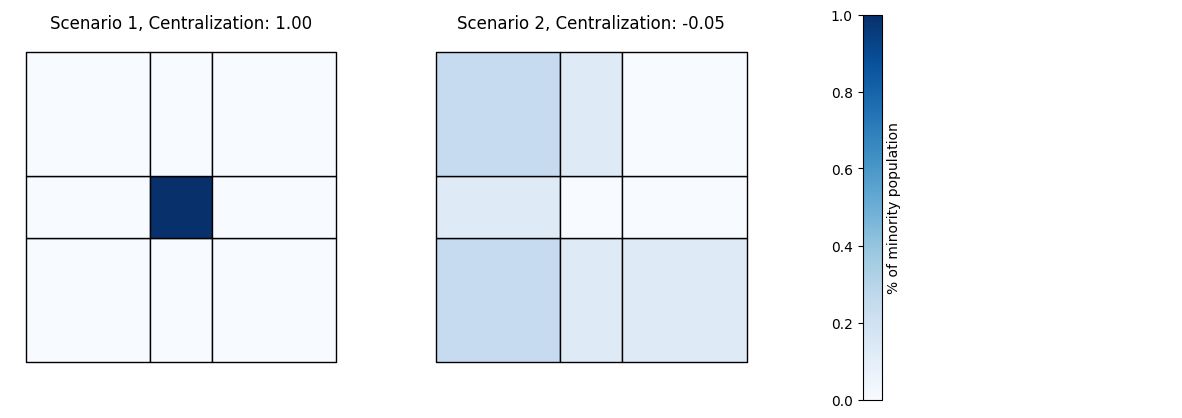

In [20]:
plt.figure(figsize=(15,5))
ax1, ax2, ax3 = plt.subplot(131), plt.subplot(132), plt.subplot(133)

grid2['xi'] = [0, 0, 0, 0, 40, 0, 0, 0, 0]
grid2['yi'] = [20, 10, 20, 10, 0, 10, 20, 10, 20]
grid2['cent'] = grid2.centroid.apply(lambda x: [x.x,x.y])
grid2['p_i'] = grid2['xi']/(grid2.xi.sum())
grid2.plot(column='p_i', edgecolor='black',ax=ax1, vmin=0, vmax=1)
ax1.set_title('Scenario 1, Centralization: {0:.2f}'.format(relative_centralization(grid2[['yi']].to_numpy(), grid2[['xi']].to_numpy(), np.array(grid2.cent.tolist()), np.array([[15, 15]]), True)))

grid2['xi'] = [10, 5, 5, 5, 0, 0, 10, 5, 0]
grid2['yi'] = [20, 15, 20, 15, 25, 10, 20, 10, 25]
grid2['p_i'] = grid2['xi']/(grid2.xi.sum())
grid2.plot(column='p_i', edgecolor='black',ax=ax2, vmin=0, vmax=1)
ax2.set_title('Scenario 2, Centralization: {0:.2f}'.format(relative_centralization(grid2[['yi']].to_numpy(), grid2[['xi']].to_numpy(), np.array(grid2.cent.tolist()),  np.array([[15,15]]), True)))

for ax in [ax1,ax2,ax3]:
    ax.axis('off')

# Create a common colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = plt.colorbar(sm, ax=ax3, orientation='vertical', location='left')
cbar.ax.yaxis.set_label_position("right")
l=cbar.ax.set_ylabel('% of minority population')

## Clustering

The fifth and last dimension of Massey and Denton's paper is Clustering. Overall, it measures how much subunits where minority members reside tend to be grouped together. It's the same as the Isolation Index mentioned earlier, except instead of just looking at a single subunit, all subunits are considered and weighed by distance. This allows modeling possible interactions with people from other subunits.

The index implemented here is the Distance-Decay Isolation Index. Essentially, it measures the probability that a minority member interacts with another minority member. Again, the formula explains the index the best

$$\sum_{i=1}^n [\frac{x_i}{X} \sum_{j=1}^n \frac{k_{ij}x_j}{t_j}]$$

The $\frac{x_j}{t_j}$ term represents the probability that one encounters a minority member in subunit $j$ (so, if the subunit is 60% minority members, this probability will be 60%). $k_{ij}$ weighs this probability by distance, so, if subunit $i$ is far away from subunit $j$, it's less likely to encounter someone from subunit $j$. The $\frac{x_i}{X}$ terms just take a weighted average of these in order to get the degree to which the average minority member experiences isolation.

Complementary to the Distance Decay Isolation intdex, there's a Distance Decay Interaction index. It computes the probability that a minority member will encounter a majority member. Since the formulation in this notebook is the same in the Census Bureau's that only includes two groups, the Distance Decay Interaction index is equal to one minus the Distance Decay Interaction index.

### Distance Decay Interaction

In [21]:
'''
Returns Distance Decay Interaction
y_i: majority (group A) population; Nx1 numpy array
x_i: minority (group B) population; Nx1 numpy array
radians: centroids of each subunit; Nx1 numpy array
centroid: population centroid of the entire unit; 1x2 numpy array
euclidean: if True, use pairwaise Euclidean distances between [radians] array
    if False, uses haversine distances between [radians] and [centroid]
'''
def distance_decay_interaction(y_i, x_i, radians, euclidean=False):
    # note: y_i=j = y_i.T
    t_i = y_i + x_i
    X = x_i.sum()
    #print(radians)
    d_ij = pairwise_distances(radians) if euclidean else haversine_distances(radians) * 6371000/1000 # distance in kilometers
    k_ij = np.exp(-d_ij)*t_i.T
    k_ij /= (k_ij.sum(axis=0)+1e-5)
    
    fact = ((x_i/(X+1e-5))*(k_ij*(y_i.T/(t_i.T+1e-6))).sum(axis=1,keepdims=True)).sum()
    xx = ((k_ij.sum(axis=1, keepdims=True)))
    #print(xx)
    return fact

'''
Returns Distance Decay Isolation
y_i: majority (group A) population; Nx1 numpy array
x_i: minority (group B) population; Nx1 numpy array
radians: centroids of each subunit; Nx1 numpy array
centroid: population centroid of the entire unit; 1x2 numpy array
euclidean: if True, use pairwaise Euclidean distances between [radians] array
    if False, uses haversine distances between [radians] and [centroid]
'''
def distance_decay_isolation(y_i, x_i, radians, euclidean=False):
    return 1 - distance_decay_interaction(y_i, x_i, radians, euclidean)
    

The exmaples below show two scenarios of the Distance Decay Isolation index. Both scenarios contain a subunit with 100% minority members, one with 100% majority members, and the other distributions are the same. However, since the all-majority and all-minority subunits are adjoining in scenario 2, it's more likely (distance-wise) that majority and minority members in these subunits will interact, so the isolation index decreases. Gini coefficient is also shown for the two scenarios for comparison: it doesn't change between scenario 1 and scenario 2

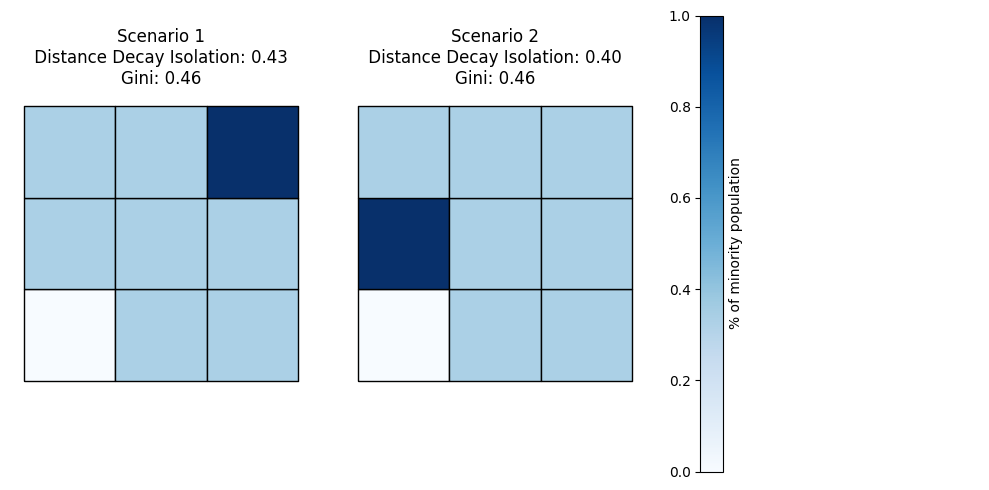

In [22]:
plt.figure(figsize=(10,5))
ax1, ax2, ax3 = plt.subplot(131), plt.subplot(132), plt.subplot(133)

grid['y_i'] = [20] + [10]*7 + [0]
grid['x_i'] = [0]+[5]*7 + [15]
grid['p_i'] = grid['x_i']/(grid.x_i+grid.y_i)
grid['cent'] = grid.centroid.apply(lambda x: [x.x,x.y])
grid.plot(column='p_i', edgecolor='black',ax=ax1, vmin=0, vmax=1)
ax1.set_title('Scenario 1\n Distance Decay Isolation: {0:.2f} \nGini: {1:.2f}'.format(distance_decay_isolation(grid[['y_i']].to_numpy(), grid[['x_i']].to_numpy(), np.array(grid.cent.tolist())/10.0, True),gini(grid[['y_i']].to_numpy(), grid[['x_i']].to_numpy())))

grid['y_i'] = [20] + [0] + [10]*7
grid['x_i'] = [0] + [15]+ [5]*7
grid['p_i'] = grid['x_i']/(grid.x_i+grid.y_i)
a = grid.plot(column='p_i', edgecolor='black',ax=ax2, vmin=0, vmax=1)
ax2.set_title('Scenario 2\n Distance Decay Isolation: {0:.2f} \nGini: {1:.2f}'.format(distance_decay_isolation(grid[['y_i']].to_numpy(), grid[['x_i']].to_numpy(), np.array(grid.cent.tolist())/10.0, True), gini(grid[['y_i']].to_numpy(), grid[['x_i']].to_numpy())))
for ax in [ax1,ax2,ax3]:
    ax.axis('off')

# Create a common colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = plt.colorbar(sm, ax=ax3, orientation='vertical', location='left')
cbar.ax.yaxis.set_label_position("right")
l=cbar.ax.set_ylabel('% of minority population')
plt.tight_layout()

## Application to Gerrymandering
So we just saw five dimensions of segregation. That's interesting information, but so what? Here, we'll look into an application to gerrymandering. Gerrymandering is defined as the manipulation of the boundaries (of an electoral constituency) so as to favor one party or class. The Brennan Center compiles and organizes lawsuits over congressional districts.

https://www.brennancenter.org/our-work/research-reports/redistricting-litigation-roundup-0

## Indexing Geographies
These functions deal with data from the US Census Bureau's TIGER database. They take in a DataFrame of a large geography (such as states) and a smaller geography unit (such as counties). Then, they return a list mapping states to the counties that make up the state

In [6]:
geo_codes = {'Tract':'1400000US'}

'''
Returns the intersection between [large_df] and [small_df]
large_df: GeoDataFrame
small_df: GeoDataFrame
large_id: column name in [large_df]. The intersection will be aggregated by [large_id]; str
'''
def get_intersection(large_df, small_df, large_id):
    idx = large_df.overlay(small_df, how='intersection',keep_geom_type=False)
    return idx.groupby(by=large_id).agg(list)

'''
Returns a file mapping regions of [df_large] which intersect with [df_small]; i.e. in format
    large_area_1: [small_intersection_1, small_intersection_2, ...],
    large_area_2: [...],...

df_small: GeoDataFrame
df_large: GeoDataFrame
small_name: name of small geographic unit (e.g. Tract); str
large_name: name of large geographic unit (e.g. CongressionalDistrict); str
small_id: column in df_small containing Census Geographic Identifier; str
large_id: column in df_large containing Census Geographic Identifier; str
small_land: column containing land area of small area; str
large_name_col: column that stores the name of the large area (e.g. `State_Name`); str
'''
def load_index(df_small, df_large, small_name, large_name, small_id = 'GEOID', large_id = 'GEOID', small_land = 'ALAND', large_name_col='NAME'):
    code_small = geo_codes[small_name] if small_name in geo_codes else ''
    code_large = geo_codes[large_name] if large_name in geo_codes else ''

    df_small[small_land] = df_small[small_land]/1000000.0 # sq m to sq km
    df_small[small_id] = code_small + df_small[small_id]
    df_large[large_id] = code_large + df_large[large_id]
    df_small['radians'] = df_small.geometry.apply(lambda g: np.array([radians(g.centroid.x),radians(g.centroid.y)]))

    df_small[small_name] = df_small[small_id]
    df_large[large_name] = df_large[large_id]
    df_small.set_index(small_id, inplace=True)
    df_large.set_index(large_id, inplace=True)

    index = get_intersection(df_large[[large_name,large_name_col,'geometry']], df_small[[small_name,small_land,'radians','geometry']], large_name)
    index[large_name_col] = index[large_name_col].apply(lambda x: x[0])
    index[small_land] = index[small_land].apply(lambda x: np.array(x))

    return index
    

    

## Loading Census Data
These functions are designed to work with Census data and an index from the previous section. Here, we are using Congressional districts and Census tracts

In [24]:
'''
Conducts lookup of census data given an index. e.g. for population data, the index row
    large_area_1:[small_intersection_1, small_intersection_2,...]
    will be mapped to
    large_area_1: [small_population_1, small_population_2, ...]

df_index: index, in format returned by load_index; DataFrame
df_small: DataFrame with Census data; DataFrame
small_id: name of small geography unit (e.g. `Tract`)
'''
def combine_with_index(df_index, df_small, small_id='Tract'):
    idx_copy = df_index.copy()#.drop(columns=['geometry'])
    newrows = []
    
    for index, row in idx_copy.iterrows():
        newrows.append(df_small.loc[row[small_id]].groupby(lambda x: True).agg(list))
    newrows = pd.concat(newrows,axis=0).reset_index(drop=True).map(lambda x: np.array([x]).T)
    newrows.index = idx_copy.index
    idx_copy[newrows.columns] = newrows
    return idx_copy

'''
Wrapper function to combine [df_small_data] with [df_index] and also add a weighted_centroid column
df_index: index, in format returned by load_index; DataFrame
df_small_data: DataFrame with Census data; DataFrame
population_column: column containing population data to use when computing population centroid; str
subset: subset of columns in df_small_data to combine with [df_index]
small_id: name of small geography unit (e.g. `Tract`)
'''
def process_census(df_index, df_small_data, population_column, subset=None, small_id='Tract'):
    if subset is None:
        subset = df_small_data.columns
    
    df_combined = combine_with_index(df_index, df_small_data[subset], small_id=small_id)
    df_combined['weighted_centroid'] = (df_combined[population_column]*df_combined['radians']).apply(lambda x: x.sum(axis=0, keepdims=True))/df_combined[population_column].apply(sum)
    

    return df_combined


In [25]:
cds = os.listdir('geo/2020/cd118')
tracts = os.listdir('geo/2020/tract')
indexes = []
for cdfile, tractfile in zip(cds, tracts):
    print(cdfile)
    df_cd, df_tractc = gpd.read_file('geo/2020/cd118/'+cdfile), gpd.read_file('geo/2020/tract/'+tractfile)
    cd_tract_index = load_index(df_tractc, df_cd, 'Tract','CongressionalDistrict', large_id='GEOID20',large_name_col='NAMELSAD20')
    indexes.append(cd_tract_index)

tl_2020_01_cd118.zip
tl_2020_02_cd118.zip
tl_2020_04_cd118.zip
tl_2020_05_cd118.zip
tl_2020_06_cd118.zip
tl_2020_08_cd118.zip
tl_2020_09_cd118.zip
tl_2020_10_cd118.zip
tl_2020_11_cd118.zip
tl_2020_12_cd118.zip
tl_2020_13_cd118.zip
tl_2020_15_cd118.zip
tl_2020_16_cd118.zip
tl_2020_17_cd118.zip
tl_2020_18_cd118.zip
tl_2020_19_cd118.zip
tl_2020_20_cd118.zip
tl_2020_21_cd118.zip
tl_2020_22_cd118.zip
tl_2020_23_cd118.zip
tl_2020_24_cd118.zip
tl_2020_25_cd118.zip
tl_2020_26_cd118.zip
tl_2020_27_cd118.zip
tl_2020_28_cd118.zip
tl_2020_29_cd118.zip
tl_2020_30_cd118.zip
tl_2020_31_cd118.zip
tl_2020_32_cd118.zip
tl_2020_33_cd118.zip
tl_2020_34_cd118.zip
tl_2020_35_cd118.zip
tl_2020_36_cd118.zip
tl_2020_37_cd118.zip
tl_2020_38_cd118.zip
tl_2020_39_cd118.zip
tl_2020_40_cd118.zip
tl_2020_41_cd118.zip
tl_2020_42_cd118.zip
tl_2020_44_cd118.zip
tl_2020_45_cd118.zip
tl_2020_46_cd118.zip
tl_2020_47_cd118.zip
tl_2020_48_cd118.zip
tl_2020_49_cd118.zip
tl_2020_50_cd118.zip
tl_2020_51_cd118.zip
tl_2020_53_cd

In [26]:
index_all = gpd.GeoDataFrame(pd.concat(indexes))#.set_index('geometry')
index_all['all_geometry'] = index_all['geometry'].apply(unary_union)
index_all=index_all.set_geometry('all_geometry')
indexes=None

In [27]:
cols_eth = ['Count!!RACE!!Total population','Count!!HISPANIC OR LATINO BY RACE!!Total population!!Not Hispanic or Latino!!White alone','Count!!RACE!!Total population!!One Race!!Black or African American','Count!!RACE!!Total population!!One Race!!Asian','Count!!HISPANIC OR LATINO BY RACE!!Total population!!Hispanic or Latino']
cols_fam = ['Count!!HOUSEHOLDS BY TYPE!!Total households','Count!!HOUSEHOLDS BY TYPE!!Total households!!Male householder, no spouse or partner present:!!Living alone','Count!!HOUSEHOLDS BY TYPE!!Total households!!Female householder, no spouse or partner present:!!Living alone','Count!!HOUSEHOLDS BY TYPE!!Total households!!Married couple household!!With own children under 18 [3]']

df_census_all = pd.read_csv('census_2020_all.csv',skiprows=1)
df_census_sub = df_census_all.set_index('Geography')[cols_eth+cols_fam]

/tmp/ipykernel_1205/6471891.py:4: DtypeWarning: Columns (74,75,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,308,309,310,311,312,313,314,315,316) have mixed types. Specify dtype option on import or set low_memory=False.
  df_census_all = pd.read_csv('census_2020_all.csv',skiprows=1)


In [28]:
newcols = ['NAMELSAD20',
 'Tract',
 'ALAND',
 'radians',
 'geometry',
 'all_geometry',
 'population',
 'population_white',
 'population_black',
 'population_asian',
 'population_latino',
 'households',
 'single_male',
 'single_female',
 'married_with_children','weighted_centroid']
df_combined = process_census(index_all, df_census_sub, 'Count!!RACE!!Total population')
df_combined.columns = newcols

In [29]:
df_cd = df_combined.copy()

In [30]:
df_ga = gpd.GeoDataFrame(df_cd[df_cd.index.str.startswith('13')][['geometry','population','population_white']].explode(['geometry','population','population_white']))
df_ga=df_ga.set_geometry('geometry')

In [31]:
df_ga['perc_population_nonwhite'] = (1-df_ga['population_white']/df_ga['population']).apply(lambda x: x[0])

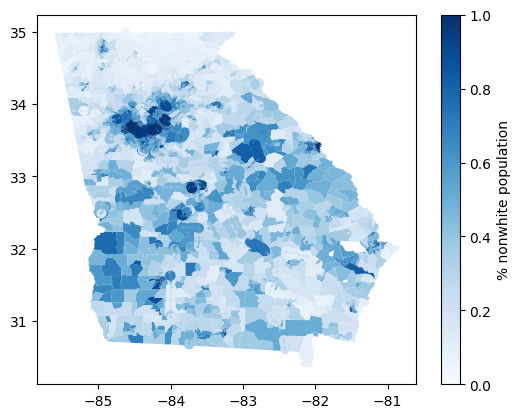

In [32]:
ax = df_ga.plot(column='perc_population_nonwhite', label='GA',vmin=0,vmax=1)
cbar = plt.colorbar(sm, ax=ax,orientation='vertical', location='right')
cbar.ax.yaxis.set_label_position("right")
l=cbar.ax.set_ylabel('% nonwhite population')

## Computing Segregation Indexes
This section computes the five segregation indexes mentioned here.

In [33]:
aggs = {'NAMELSAD20':lambda x: x,
 'Tract':lambda x:'',
 'ALAND':sum,
 'radians':lambda x: np.array(x).mean(axis=0,keepdims=True),
 'geometry':lambda x:[],
 'all_geometry':lambda x:x,
 'population':sum,
 'population_white':sum,
 'population_black':sum,
 'population_asian':sum,
 'population_latino':sum,
 'households':sum,
 'single_male':sum,
 'single_female':sum,
 'married_with_children':sum, 'weighted_centroid':lambda x: x}

for col in aggs:
    df_cd[col]=df_cd[col].apply(aggs[col])

In [34]:
_STATE_FIPS_MAP = {'02':'ak', '01':'al', '05':'ar', '04':'az', '06':'ca', '08':'co', '09':'ct', '10':'de', '12':'fl', '13':'ga', 
                   '15':'hi', '19':'ia', '16':'id', '17':'il', '18':'in', '20':'ks', '21':'ky', '22':'la', '25':'ma', '24':'md', 
                   '23':'me', '26':'mi', '27':'mn', '29':'mo', '28':'ms', '30':'mt', '37':'nc', '38':'nd', '31':'ne', '33':'nh',
                   '34':'nj', '35':'nm', '32':'nv', '36':'ny', '39':'oh', '40':'ok', '41':'or', '42':'pa', '44':'ri', '45':'sc',
                   '46':'sd', '47':'tn', '48':'tx', '49':'ut', '51':'va', '50':'vt', '53':'wa', '55':'wi', '54':'wv', '56':'wy', '11':'dc'}

In [35]:
df_cd['State_Fips'] = df_cd.index.map(lambda x: x[:2])
df_cd['State'] = df_cd['State_Fips'].apply(lambda x: _STATE_FIPS_MAP[x])

df_cd = df_cd.reset_index().groupby(by=['State']).agg(list)
df_cd['radians'] = df_cd['radians'].apply(lambda x: np.array(x)[:,0,:])
df_cd['weighted_centroid'] = df_cd['weighted_centroid'].apply(lambda x: np.array(x)[:,0,:].mean(axis=0,keepdims=True))

df_cd['population_black'] = df_cd['population_black'].apply(lambda x: np.array(x))
df_cd['population_white'] = df_cd['population_white'].apply(lambda x: np.array(x))
df_cd['ALAND'] = df_cd['ALAND'].apply(lambda x: np.array([x]).T)

In [36]:
df_cd['gini_bw'] = df_cd.apply(lambda x: gini(x.population_white, x.population_black), axis=1)
df_cd['isolation_bw'] = df_cd.apply(lambda x: isolation(x.population_white, x.population_black), axis=1)
df_cd['concentration_bw'] = df_cd.apply(lambda x: concentration(x.population_white, x.population_black,x.ALAND), axis=1)
df_cd['relative_centralization_bw'] = df_cd.apply(lambda x: relative_centralization(x.population_white, x.population_black, x.radians, x.weighted_centroid), axis=1)
df_cd['dd_isolation'] = df_cd.apply(lambda x: distance_decay_isolation(x.population_white, x.population_black, x.radians), axis=1)
df_cd['tot']=((df_cd[['gini_bw','isolation_bw','concentration_bw','relative_centralization_bw','dd_isolation']].abs() - df_cd[['gini_bw','isolation_bw','concentration_bw','relative_centralization_bw','dd_isolation']].abs().mean())/df_cd[['gini_bw','isolation_bw','concentration_bw','relative_centralization_bw','dd_isolation']].std()).sum(axis=1)

In [37]:
df_cd.sort_values(by=['tot'], ascending=False)

,CongressionalDistrict,NAMELSAD20,Tract,ALAND,radians,geometry,all_geometry,population,population_white,population_black,...,single_female,married_with_children,weighted_centroid,State_Fips,gini_bw,isolation_bw,concentration_bw,relative_centralization_bw,dd_isolation,tot
State,,,,,,,,,,,,,,,,,,,,,
ny,"[3601, 3602, 3603, 3604, 3605, 3606, 3607, 360...","[Congressional District 1, Congressional Distr...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[[1929.3645339999996], [1109.8866880000005], [...","[[-1.2745565742791969, 0.71350055749176], [-1....","[[], [], [], [], [], [], [], [], [], [], [], [...","[POLYGON ((-73.497333 40.92396, -73.497134 40....","[[938100], [950045], [1038222], [977048], [956...","[[654478], [560866], [581236], [483121], [1465...","[[46761], [88827], [47905], [172155], [361859]...",...,"[[42194], [38418], [48410], [39432], [41377], ...","[[69999], [65009], [83855], [71763], [53095], ...","[[-1.3021009867303055, 0.7237569928888461]]","[36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 3...",0.634733,0.426378,7.945478e-01,0.115551,0.421175,6.521082
mo,"[2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908]","[Congressional District 1, Congressional Distr...","[, , , , , , , ]","[[1056.5052710000004], [9165.071388000004], [3...","[[-1.5760945709558782, 0.675022397397999], [-1...","[[], [], [], [], [], [], [], []]",[GEOMETRYCOLLECTION (POLYGON ((-90.487873 38.6...,"[[886537], [1090045], [1120481], [1028278], [9...","[[402307], [907664], [940780], [861667], [5530...","[[365241], [42269], [62703], [44632], [178028]...",...,"[[80430], [68895], [60909], [55634], [65456], ...","[[41798], [89483], [82777], [73722], [56582], ...","[[-1.6097447856492204, 0.6709034632424863]]","[29, 29, 29, 29, 29, 29, 29, 29]",0.598891,0.292771,6.187126e-01,-0.485585,0.292771,6.369963
md,"[2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408]","[Congressional District 1, Congressional Distr...","[, , , , , , , ]","[[10314.191538000001], [3354.173457], [2075.99...","[[-1.3273977709459315, 0.6819620806781876], [-...","[[], [], [], [], [], [], [], []]","[POLYGON ((-76.23595 37.88959, -76.235933 37.8...","[[848060], [1061103], [1016763], [969214], [99...","[[610582], [604501], [571782], [125290], [3950...","[[126282], [270179], [192503], [525599], [4289...",...,"[[46538], [67796], [47766], [53352], [48576], ...","[[56991], [74446], [84581], [54533], [72169], ...","[[-1.34050626204254, 0.6832413602162516]]","[24, 24, 24, 24, 24, 24, 24, 24]",0.470181,0.498958,4.800909e-01,0.202802,0.498949,6.214754
pa,"[4201, 4202, 4203, 4204, 4205, 4206, 4207, 420...","[Congressional District 1, Congressional Distr...","[, , , , , , , , , , , , , , , , ]","[[2332.6972020000017], [236.28389600000008], [...","[[-1.3107206291453612, 0.7025436869999425], [-...","[[], [], [], [], [], [], [], [], [], [], [], [...","[POLYGON ((-74.987451 40.123571, -74.987573 40...","[[935930], [915839], [959761], [1249791], [935...","[[748868], [356604], [329036], [886654], [5441...","[[38370], [247639], [462427], [142449], [22826...",...,"[[49160], [60088], [92146], [74744], [57797], ...","[[72558], [44487], [35614], [94293], [63721], ...","[[-1.3433229198008836, 0.7058960733870211]]","[42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 4...",0.599592,0.293174,6.911687e-01,-0.189214,0.293108,4.700077
mi,"[2601, 2602, 2603, 2604, 2605, 2606, 2607, 260...","[Congressional District 1, Congressional Distr...","[, , , , , , , , , , , , ]","[[72654.78107500002], [33353.99680299999], [38...","[[-1.4949296275864035, 0.7919490982562579], [-...","[[], [], [], [], [], [], [], [], [], [], [], [...","[POLYGON ((-83.811691 43.87502, -83.83197 43.8...","[[817193], [1054772], [940848], [945783], [954...","[[732307], [927313], [690183], [731506], [8019...","[[7388], [22345], [90321], [69146], [42912], [...",...,"[[54937], [51629], [52063], [52774], [52413], ...","[[45743], [71497], [68233], [68158], [61894], ...","[[-1.4699552360577604, 0.7479892638155511]]","[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 2...",

In [38]:
df_combined['gini'] = df_combined.apply(lambda x: gini(x.population_white, x.population_black), axis=1)
df_combined['isolation'] = df_combined.apply(lambda x: isolation(x.population_white, x.population_black), axis=1)
df_combined['concentration'] = df_combined.apply(lambda x: concentration(x.population_white, x.population_black,x.ALAND), axis=1)
df_combined['relative_centralization'] = df_combined.apply(lambda x: relative_centralization(x.population_white, x.population_black, x.radians, x.weighted_centroid), axis=1)
df_combined['dd_isolation'] = df_combined.apply(lambda x: distance_decay_isolation(x.population_white, x.population_black, x.radians), axis=1)
df_combined['total']=((df_combined[['gini','isolation','concentration','relative_centralization','dd_isolation']].abs() - df_combined[['gini','isolation','concentration','relative_centralization','dd_isolation']].abs().mean())/df_combined[['gini','isolation','concentration','relative_centralization','dd_isolation']].std()).sum(axis=1)

In [39]:
df_combined['State_Fips'] = df_combined.index.map(lambda x: x[:2])
df_combined['State'] = df_combined['State_Fips'].apply(lambda x: _STATE_FIPS_MAP[x])

Here, the segregation indexes of each state have been aggregated simply by computing standardized values and adding them (a good technique I saw from the Environmental Protection Agency). Of the top 10 states by segregation indexes (excluding Washington DC as they have no voting representation in Congress), Louisiana, Georgia, Arkansas, Ohio, and Alabama have faced litigation for potentially violating Section 2 of the Voting Rights Act. Additionally, New York, Maryland, and New Jersey have faced litigation for partisan gerrymandering.

In [45]:
df_combined.reset_index().groupby(by=['State']).mean(numeric_only=True).sort_values(by=['gini'], ascending=False).iloc[1:11]

,gini,isolation,concentration,relative_centralization,dd_isolation,total
State,,,,,,
oh,0.762583,0.394472,-0.000013,0.078738,0.294727,1.668531
ny,0.762485,0.506661,-0.000011,0.114271,0.373883,2.291721
mi,0.761123,0.400316,-0.000023,0.068023,0.293398,1.187950
ar,0.751144,0.429228,-0.000014,0.073936,0.345458,1.756282
il,0.750060,0.437292,-0.000011,0.016308,0.311267,1.315107
ct,0.749896,0.405418,-0.000023,0.169621,0.330079,1.607312
in,0.742019,0.317986,-0.000019,0.144215,0.209664,0.245113
nj,0.738001,0.487250,-0.000008,0.047401,0.365876,1.769435
ri,0.724709,0.306887,-0.000022,0.280783,0.225718,0.753318


## Conclusion
Just from a very simple scoring formula, we've been able to identify possible cases of gerrymandering just using the segregation indexes alone. Combining wit hadditional information and using more complex techniques could serve as an even more reliable indicator of districts that are likely to result in lawsuits.

#  END